In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam, SGD
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

Using TensorFlow backend.


In [2]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

In [3]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# model = ssd_512(image_size=(img_height, img_width, 3),
#                 n_classes=20,
#                 mode='inference',
#                 l2_regularization=0.0005,
#                 scales=[0.07, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05], # The scales for MS COCO are [0.04, 0.1, 0.26, 0.42, 0.58, 0.74, 0.9, 1.06]
#                 aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
#                                          [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
#                                          [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
#                                          [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
#                                          [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
#                                          [1.0, 2.0, 0.5],
#                                          [1.0, 2.0, 0.5]],
#                two_boxes_for_ar1=True,
#                steps=[8, 16, 32, 64, 128, 256, 512],
#                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
#                clip_boxes=False,
#                variances=[0.1, 0.1, 0.2, 0.2],
#                normalize_coords=True,
#                subtract_mean=[123, 117, 104],
#                swap_channels=[2, 1, 0],
#                confidence_thresh=0.5,
#                iou_threshold=0.45,
#                top_k=200,
#                nms_max_output_size=400)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.
weights_path = 'output.h5'

model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

# adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

# model.compile(optimizer=sgd, loss=ssd_loss.compute_loss, metrics=['accuracy'])
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = 'GreenParking/0027_06458_b.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

In [6]:
y_pred = model.predict(input_images)
print(y_pred)

[[[ 2.2065136e-01  7.7934867e-01 -5.6885719e-01 ...  1.0000000e-01
    2.0000000e-01  2.0000000e-01]
  [ 4.0317056e-01  5.9682947e-01  3.3923596e-01 ...  1.0000000e-01
    2.0000000e-01  2.0000000e-01]
  [ 6.7723149e-01  3.2276848e-01  1.8049991e-01 ...  1.0000000e-01
    2.0000000e-01  2.0000000e-01]
  ...
  [ 4.9578679e-01  5.0421327e-01  5.3435517e-04 ...  1.0000000e-01
    2.0000000e-01  2.0000000e-01]
  [ 4.9741191e-01  5.0258809e-01 -1.0085513e-03 ...  1.0000000e-01
    2.0000000e-01  2.0000000e-01]
  [ 5.0378710e-01  4.9621290e-01  7.6879086e-03 ...  1.0000000e-01
    2.0000000e-01  2.0000000e-01]]]


In [7]:
confidence_threshold = 0.5

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 0.22  0.78 -0.57 ...  0.1   0.2   0.2 ]
 [ 0.4   0.6   0.34 ...  0.1   0.2   0.2 ]
 [ 0.33  0.67  0.67 ...  0.1   0.2   0.2 ]
 ...
 [ 0.49  0.51  0.   ...  0.1   0.2   0.2 ]
 [ 0.5   0.5   0.   ...  0.1   0.2   0.2 ]
 [ 0.5   0.5  -0.   ...  0.1   0.2   0.2 ]]


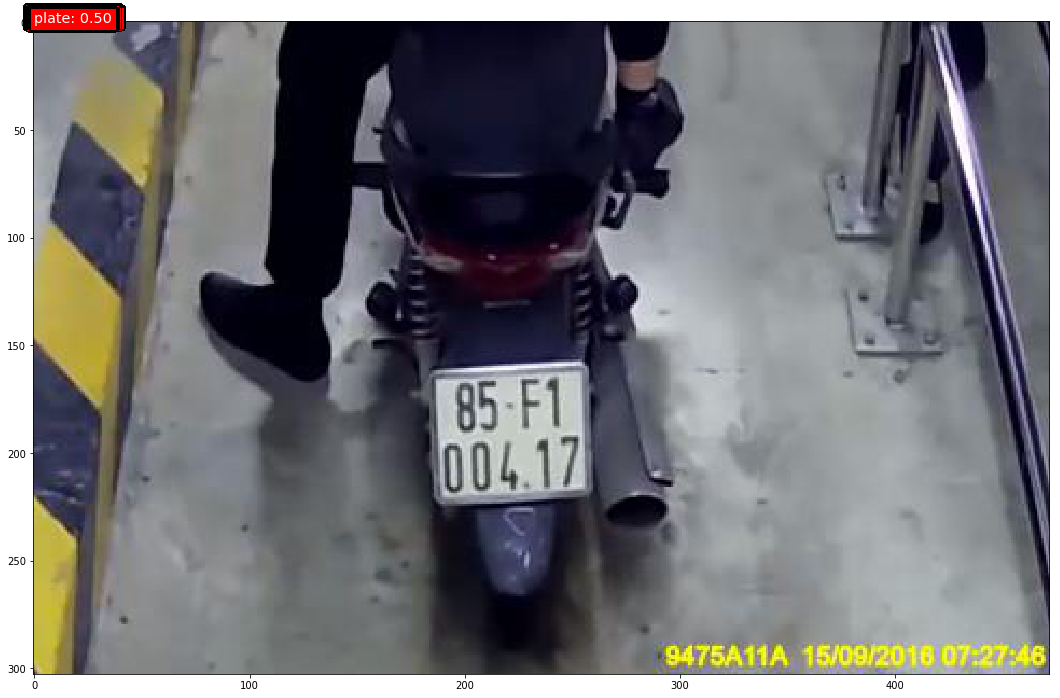

In [8]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['plate']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_thresh[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})